# Assignment 3: Technical Report
## Finding fast growing firms!

> Summary report and data can be found on my [GitHub page](https://github.com/JustJAG/Prediction_with_ML_for_Economists/tree/main/Assignment_3_finding_fast_growing_firms)

Task is to build a model to predict fast growth of firms using the bisnode-firms data

* You should design the target (fast growth), it can be measured in any way you like over one (2013 vs 2012) or two years (2014 vs 2012)

* You need to argue for your choice, discussing a few alternatives.

* Build three different models and pick the one you like the most
 * Should include at least one logit and one random forest
 
### PART I: Probability prediction
* Predict probabilities
* Look at cross-validated performance and pick your favorite model

### PART II: Classification
* Think about the business problem, and define your loss function (like FP=X dollars, FN=Y dollars)
* For each model, predict probabilities, look for the optimal classification threshold, calculate expected loss with your loss function. 
* Pick the model that has the smallest average (over 5 folds) expected loss

### PART III Discussion of results
* Show a confusion table (on a selected fold or holdout set)
* Discuss results, evaluate how useful your model may be

## Scoring

* Data prep, label and feature engineering (25%)
* Model building and probability prediction and model selection (25%)
* Classification (20%)

* Discussion of steps, decisions and results (15%)
    * Explain shortly every modelling decisions
    * At the end please give a 2-3 paragraph discussion of what you found.

* Quality of the write-up (15%)

# Part 0: Preparing Data
## Importing Data

The first thing to be done is to get data, import it, and keep only the variables and observations I need for models

In [1]:
### SETTING UP DIRECTORIES

# import packages
import pandas as pd
import os
import numpy as np
import sys
import warnings
from pathlib import Path
import patsy

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
from mizani.formatters import percent_format
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# set working directory for da_data_repo -- replace the
os.chdir('C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms')

# location folders
data_in = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\raw\\"
data_out = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\clean\\"
results = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\results\\"
func = 'C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\'

sys.path.append(func)
from py_helper_functions import *

In [2]:
# read csv
current_csv_path = os.path.join(data_in,"cs_bisnode_panel.csv")
data = pd.read_csv(current_csv_path)

The data has 287,829 rows and 48 columns. We need to start with the panel for 2012-2014. Let's delete all other years.

In [3]:
data=data.query('year<=2014 & year>=2010')

Now we are left with 140,100 observations

Look at variables with many missing variables

`data.isnull().sum()` shows that 'COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', and 'D' have a lot of missing values (more than 90%). I will delete these columns

In [4]:
# Set options to see all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# drop columns with many NAs
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'])

## Target variable
I define fast growing firm as the firm which has high percentage change in sales over a period of time.

As I expect the distribution of sales to be skewed, I might swith to log values. 

In [6]:
data['sales'].describe()

count    1.363840e+05
mean     4.588651e+05
std      3.769455e+06
min     -2.553889e+05
25%      3.192593e+03
50%      2.622593e+04
75%      1.015713e+05
max      1.110294e+08
Name: sales, dtype: float64

There are negative values of sales. I will replace them with 0.

I will also create a log of sales variable

In [7]:
# replace negative values with zeros
data['sales']=np.where(data['sales'] < 0, 1, data['sales'])
# create log of sales
data = data.assign(
    ln_sales = np.where(data['sales'] > 0 , np.log(data['sales']), (np.where(data['sales'].isna(),np.nan,0))), #NaN remain NaN
  )

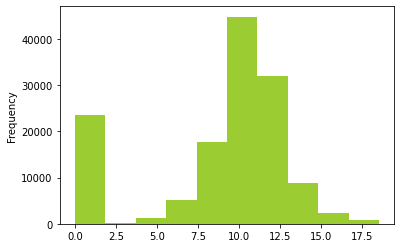

In [8]:
ax=data['ln_sales'].plot(kind='hist', color='#9BCC31')

In [9]:
# create changes of ln_sales from 2011 to 2012
data['diff_ln_sales']=data['ln_sales']-data.groupby('comp_id')['ln_sales'].shift(1)

In [10]:
# create age and new variables
data['age']=np.where(data['year']-data['founded_year'] < 0, 0, data['year']-data['founded_year'])
data['new']=np.where(((data['age']<=1)|(data['balsheet_notfullyear']==1)),1,(np.where(data['age'].isna(),np.nan,0)))

# adjust 
data["diff_ln_sales"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["diff_ln_sales"])
)
data["new"] = np.where(data["diff_ln_sales"].isna(), 1, data["new"])
data["diff_ln_sales"] = np.where(
    data["diff_ln_sales"].isna(), 0, data["diff_ln_sales"]
)

In [11]:
# create percentage changes of ln_sales from 2012 to 2013 and from 2012 to 2014 
data['d1_ln_sales'] = (data.groupby('comp_id')['ln_sales'].shift(-1) - data['ln_sales'] )/ data['ln_sales']
data['d2_ln_sales'] = (data.groupby('comp_id')['ln_sales'].shift(-2) - data['ln_sales'] )/ data['ln_sales']

# create percentage changes of sales from 2012 to 2013 and from 2012 to 2014 
data['d1_sales'] = (data.groupby('comp_id')['sales'].shift(-1) - data['sales'] )/ data['sales']
data['d2_sales'] = (data.groupby('comp_id')['sales'].shift(-2) - data['sales'] )/ data['sales']

Now look at cross-section

In [12]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data['status_alive'] = (data['sales'] > 0 & (False == data['sales'].isna())).astype(int)

# look at cross section
data=data.query('year==2012 & status_alive == 1')

# look at firms below 10m euro revenues and above 1000 euros
data=data.query('sales <= 10000000 & sales>=1000')

Now we are left with 21,723 observations.

It's time to define a *fast_growth* variable, which is 1 for firms who has at least 20% growth in sales every year. That is where *d1_sales* $\ge 0.2$ and *d2_sales* $\ge 0.44$ (because $1.2*1.2 = 1.44$)

In [13]:
data["fast_growth"] = (
    (data["d1_sales"] >= 0.2)
    & (data["d2_sales"] >= 0.44)
).astype(int)

In [14]:
print("The number of fast growing firms is {} which is {:.2f} percent of all firms".format(data.fast_growth.sum(), 100*data.fast_growth.sum()/len(data)))

The number of fast growing firms is 3726 which is 17.15 percent of all firms


## Feature Engineering

I will create extra variables for the models here

In [15]:
# change some industry category codes
data['ind2_cat']=data['ind2'].copy()
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [16]:
# Firm characteristics
data['age2'] = data['age']**2
data['foreign_management'] = np.where(data['foreign'] >= 0.5, 1, np.where(data['foreign'].isna(), np.nan, 0))
data['gender_m'] = data['gender'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

In [17]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0)
data['flag_asset_problem'] = np.where(((data['intang_assets'].isna()) | (data['curr_assets'].isna()) | (data['fixed_assets'].isna())), np.nan, data['flag_asset_problem'])
data.groupby('flag_asset_problem').count()['comp_id']

flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [18]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [19]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [20]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [21]:
# divide all pl_names elements by sales and create new column for it
data[[col +'_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [22]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col +'_bs']] = np.where(data['total_assets_bs'].isna(), np.nan, data[col +'_bs'])

In [23]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [24]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [25]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [26]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [27]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [28]:
data['labor_avg'].describe()

count    18569.000000
mean         0.621691
std          1.586800
min          0.083333
25%          0.097222
50%          0.229167
75%          0.513889
max         42.118057
Name: labor_avg, dtype: float64

In [29]:
data['labor_avg_mod'].describe()

count    21723.000000
mean         0.621691
std          1.467084
min          0.083333
25%          0.125000
50%          0.284722
75%          0.621691
max         42.118057
Name: labor_avg_mod, dtype: float64

In [30]:
data = data.drop(['labor_avg'], axis=1)

In [31]:
# create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['fast_growth_f'] = data['fast_growth'].astype("category")
data['fast_growth_f'] = data['fast_growth_f'].cat.rename_categories(['no_fast_growth', 'fast_growth'])

In [32]:
########################################################################
 # sales squared
########################################################################
data['ln_sales_sq'] = data['ln_sales']**2

## Create financial ratios variables

* ROE = inc_bef_tax / share_eq_bs
* ROA = inc_bef_tax / total_assets_bs
* ROTA = (inc_bef_tax + amort) / total_assets_bs
* Current Ratio = curr_assets_bs / curr_liab_bs

In [33]:
# ROE
data = data.assign(ROE=lambda x: x["inc_bef_tax"] / x["share_eq"])

# ROA
data = data.assign(ROA=lambda x: x["inc_bef_tax"] / x["total_assets_bs"])

# ROTA
data = data.assign(ROTA=lambda x: (x["inc_bef_tax"]+x["amort"]) / x["total_assets_bs"])

# Current Ratio (CR)
data = data.assign(CR=lambda x: x["curr_assets_bs"] / x["curr_liab_bs"])

In [34]:
data[(data['ROA'] == np.inf) | (data['ROA'] == -np.inf)]['ROA'].count()

62

In [35]:
data[(data['ROE'] == np.inf) | (data['ROE'] == -np.inf)]['ROE'].count()

7

In [36]:
data[(data['CR'] == np.inf) | (data['CR'] == -np.inf)]['CR'].count()

388

In [37]:
data.CR.isnull().values.ravel().sum()

77

There are financial ratios variables with inf in the data.
That is because *share_eq* in ROE or *total_assets_bs* in ROA/ROTA or *curr_liab_bs* in CR are equal to zero.

I will replace those values with median values.

In [38]:
data["ROE"] = np.where( (data["ROE"] == np.inf) | (data["ROE"] == -np.inf),
    data["ROE"].median(),
    data["ROE"]
)

data["ROA"] = np.where( (data["ROA"] == np.inf) | (data["ROA"] == -np.inf),
    data["ROA"].median(),
    data["ROA"]
)

data["ROTA"] = np.where( (data["ROTA"] == np.inf) | (data["ROTA"] == -np.inf),
    data["ROTA"].median(),
    data["ROTA"]
)

data["CR"] = np.where( (data["CR"] == np.inf) | (data["CR"] == -np.inf) | (data.CR.isnull() == True),
    data["CR"].median(),
    data["CR"]
)

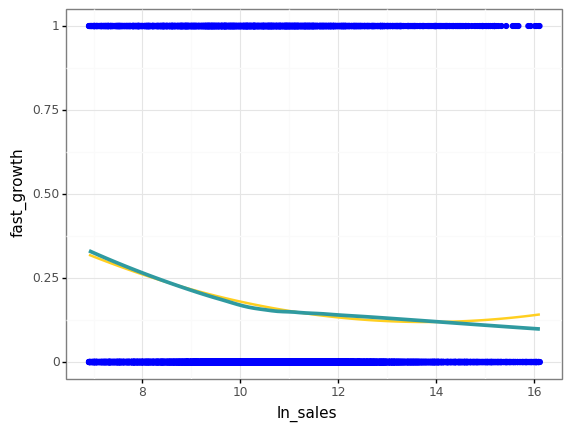

<ggplot: (136465136339)>

In [39]:
ggplot(data, aes(x = "ln_sales", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color=color[3], se = False) + geom_smooth(
    method = "loess", color=color[4], se = False, size=1.5, span=0.9) + labs(
    x="ln_sales", y="fast_growth"
) + theme_bw()

In [40]:
# Linear regressions
ols_s = smf.ols('fast_growth ~ ln_sales + ln_sales_sq', data = data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     152.3
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           2.03e-66
Time:                        16:59:12   Log-Likelihood:                -9479.3
No. Observations:               21723   AIC:                         1.896e+04
Df Residuals:                   21720   BIC:                         1.899e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9215      0.074     12.399      

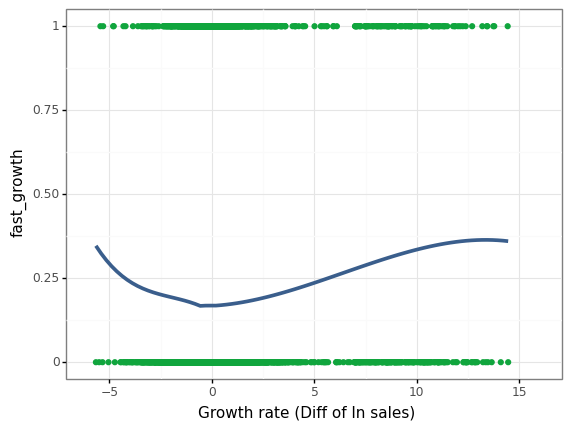

<ggplot: (136467705269)>

In [56]:
ggplot(data, aes(x = 'diff_ln_sales', y = 'fast_growth')) + geom_point(
    color=color[1]) + geom_smooth(
    method = 'loess', color=color[0], se = False, size=1.5, span=0.9) + labs(
    x='Growth rate (Diff of ln sales)', y='fast_growth') + scale_x_continuous(
    limits=(-6, 16), breaks = seq(-5, 16, by = 5)
) + theme_bw() 

The shape is weird now. Let us look on the values from 0 to 8. We expect *fast_growth* to increase as growth rate is increasing

I will winsorize *diff_ln_sales*: 
1. Replace values below -0.5 with -0.5
2. Replace values above 14 with 14

In [57]:
# generate winsorized variables 

data['flag_low_diff_ln_sales'] = np.where(data['diff_ln_sales'] < -0.5, 1, 0)
data['flag_high_diff_ln_sales'] = np.where(data['diff_ln_sales'] > 14, 1, 0)
data['diff_ln_sales_mod'] = np.where(data['diff_ln_sales'] < -0.5, -0.5, 
                                        np.where(data['diff_ln_sales'] > 14, 14, data['diff_ln_sales']))
data['diff_ln_sales_mod_sq'] = data['diff_ln_sales_mod']**2

Below I depict how winsorized variable looks like:

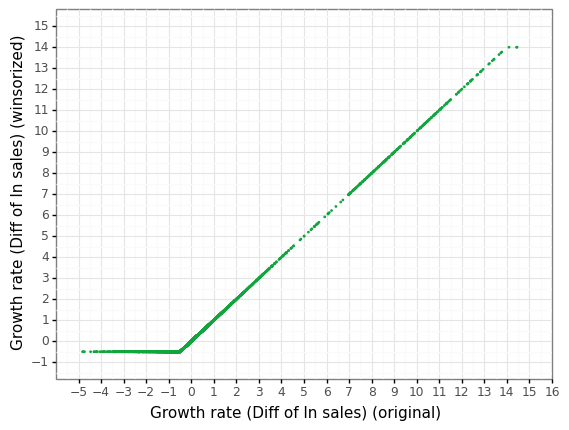

<ggplot: (136480310501)>

In [75]:
ggplot(data, aes(x = 'diff_ln_sales', y = 'diff_ln_sales_mod')) + geom_point(
    size = 0.1, color = color[1]) + labs(
    x='Growth rate (Diff of ln sales) (original)', y='Growth rate (Diff of ln sales) (winsorized)'
) + scale_x_continuous(limits=(-5, 15), breaks = seq(-5, 17, by = 1)
) + scale_y_continuous(limits=(-1, 15), breaks = seq(-1, 17, by = 1)
) + theme_bw()  

In [61]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [62]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    19036.000000
mean         8.701828
std          6.924531
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [63]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

In [65]:
# drop unnecessary columns
data = data.drop(['d1_ln_sales', 'd2_ln_sales', 'd1_sales', 'd2_sales', 'exit_date' , 'birth_year', 'exit_year'], axis=1)

In [76]:
data.to_csv(data_out+'bisnode_firms_clean.csv',index=False)

In [77]:
data.describe()

,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,year,founded_year,ceo_count,foreign,female,inoffice_days,nace_main,ind2,ind,ln_sales,diff_ln_sales,age,new,status_alive,fast_growth,age2,foreign_management,flag_asset_problem,total_assets_bs,extra_exp_pl,extra_inc_pl,extra_profit_loss_pl,inc_bef_tax_pl,inventories_pl,material_exp_pl,profit_loss_year_pl,personnel_exp_pl,intang_assets_bs,curr_liab_bs,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,extra_exp_pl_flag_high,extra_inc_pl_flag_high,inventories_pl_flag_high,material_exp_pl_flag_high,personnel_exp_pl_flag_high,curr_liab_bs_flag_high,liq_assets_bs_flag_high,subscribed_cap_bs_flag_high,extra_exp_pl_flag_error,extra_inc_pl_flag_error,inventories_pl_flag_error,material_exp_pl_flag_error,personnel_exp_pl_flag_error,curr_liab_bs_flag_error,liq_assets_bs_flag_error,subscribed_cap_bs_flag_error,extra_profit_loss_pl_flag_low,inc_bef_tax_pl_flag_low,profit_loss_year_pl_flag_low,share_eq_bs_flag_low,extra_profit_loss_pl_flag_high,inc_bef_tax_pl_flag_high,profit_loss_year_pl_flag_high,share_eq_bs_flag_high,extra_profit_loss_pl_flag_zero,inc_bef_tax_pl_flag_zero,profit_loss_year_pl_flag_zero,share_eq_bs_flag_zero,extra_profit_loss_pl_quad,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,ln_sales_sq,ROE,ROA,ROTA,CR,flag_low_diff_ln_sales,flag_high_diff_ln_sales,diff_ln_sales_mod,diff_ln_sales_mod_sq
count,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,19036.000000,19036.000000,19036.0,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.0,19036.000000,19036.000000,19036.000000,19036.000000,1.903600e+04,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19034.000000,19035.000000,19035.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000
mean,1.529275e+11,9.274374e+03,9.914862e+04,8.567028e+04,418.017165,1.641894e+03,1.220200e+03,1.451590e+05,5.869079e+03,3.365268e+03,2.568260e+04,2.458475e+04,1.676940e+05,5.353874e+04,5.230908e+02,2.357734e+05,9.144960e+04,3.030463e+04,1.334858e+05,0.002049,356.775688,0.052427,2012.0,2003.298172,1.283568,0.094705,0.260368,3010.446859,4829.194526,48.069290,2.686436,10.757966,0.109018,8.701828,0.183547,1.0,0.165108,123.668418,0.105800,0.000683,2.476728e+05,0.001924,0.007825,0.005911,-0.107757,0.101112,0.718660,-0.127314,0.306791,0.006546,0.546797,0.343235,0.225676,0.647278,0.038447,0.309755,0.328644,0.000368,0.002469,0.022221,0.156861,0.039924,0.285407,0.000263,0.124448,0.000158,0.000105,0.000210,0.000210,0.000315,0.000473,0.001418,0.000053,0.000158,0.069763,0.069657,0.229670,0.002259,0.004570,0.003940,0.008615,0.868197,0.001734,0.031257,0.003257,0.004884,0.158616,0.146067,0.4899

# Part I: Probability prediction

## Define helper functions

In [78]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

## Define variable sets 

In [86]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap", "amort"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl", "ROE", "ROA", "ROTA", "CR"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["diff_ln_sales_mod", "diff_ln_sales_mod_sq",
         "flag_low_diff_ln_sales", "flag__diff_ln_sales"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [99]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1]'], axis=1)

In [100]:
# Define X1
basevars = data[["ln_sales", "ln_sales_sq", "diff_ln_sales_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["ln_sales", "ln_sales_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["ln_sales", "ln_sales_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [102]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):diff_ln_sales_mod \
                + C(ind2_cat):ln_sales + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + ln_sales:age + ln_sales:female + ln_sales:profit_loss_year_pl \
                + ln_sales:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [103]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [104]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales", "diff_ln_sales"] + rawvars + hr + qualityvars], firm], axis=1)

In [105]:
y = data['fast_growth']

## Check simple linear and logistic models

In [106]:
# Check simplest model X1
ols_modelx1 = LinearRegression().fit(X1, y)

In [107]:
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.0195
r2:  0.0195
MAE:  0.2703
MSE:  0.1352
RMSE:  0.3676


In [110]:
glm_modelx1 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.004
r2:  -0.2
MAE:  0.1654
MSE:  0.1654
RMSE:  0.4067


In [112]:
# Check model X2
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0098
r2:  -0.202
MAE:  0.1657
MSE:  0.1657
RMSE:  0.407


In [113]:
coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,ln_sales,-0.432528
1,ln_sales_sq,0.012850
2,diff_ln_sales_mod,0.094043
3,profit_loss_year_pl,-0.317338
4,C(ind2_cat)[27.0],0.050603
5,C(ind2_cat)[28.0],0.039379
6,C(ind2_cat)[29.0],0.473840
7,C(ind2_cat)[30.0],0.234264
8,C(ind2_cat)[33.0],-0.019219
9,C(ind2_cat)[55.0],-0.267714


In [114]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
mx2.summary()

Optimization terminated successfully.
         Current function value: 0.427921
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ln_sales                   -0.0571      0.015     -3.848      0.000      -0.086      -0.028
ln_sales_sq                 0.0017      0.001      2.470      0.014       0.000       0.003
diff_ln_sales_mod           0.0124      0.002      7.381      0.000       0.009       0.016
profit_loss_year_pl        -0.0419      0.008     -5.086      0.000      -0.058      -0.026
C(ind2_cat)[27.0]           0.0067      0.019      0.355      0.723      -0.030       0.044
C(ind2_cat)[28.0]           0.0052      0.014      0.360      0.719      -0.023       0.033
C(ind2_cat)[29.0]           0.0626      0.023      2.716      0.007       0.017       0.108
C(ind2_cat)[30.0]           0.0309      0.029      1.050      0.294      -0.027       0.089
C(ind2_cat)[33.0]          -0.0025      0.014     -0.178      0.859      -0.030       0.025
C(ind2_cat)[55.0]          -0.0353      0.014     -2.450      0.014      -0.064      -0.007
C(ind2_cat)[56.0]          -0.0490      0.013     -3.894      0.000      -0.074      -0.024
fixed_assets_bs             0.0243      0.008      2.875      0.004       0.008       0.041
share_eq_bs                 0.0318      0.007      4.661      0.000       0.018       0.045
curr_liab_bs                0.0461      0.012      3.970      0.000       0.023       0.069
curr_liab_bs_flag_high     -0.0394      0.010     -3.891      0.000      -0.059      -0.020
curr_liab_bs_flag_error     0.0591      0.107      0.550      0.582      -0.151       0.270
age                        -0.0083      0.000    -18.173      0.000      -0.009      -0.007
foreign_management          0.0128      0.009      1.477      0.140      -0.004       0.030
===========================================================================================
"""

In [119]:
# Check model X3
glm_modelx3 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X3, y)
regression_results(y, glm_modelx3.predict(X3))

explained_variance:  -0.0125
r2:  -0.1939
MAE:  0.1646
MSE:  0.1646
RMSE:  0.4057


In [120]:
# Check model X4
glm_modelx4 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_modelx4.predict(X4))

explained_variance:  -0.011
r2:  -0.1661
MAE:  0.1607
MSE:  0.1607
RMSE:  0.4009


In [121]:
# Check model X5
glm_modelx5 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X5, y)
regression_results(y, glm_modelx5.predict(X5))

explained_variance:  -0.0051
r2:  -0.157
MAE:  0.1595
MSE:  0.1595
RMSE:  0.3994


## Separate train and holdout data

In [124]:
data = data.reset_index()

In [126]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [127]:
print('Total')
print(data['fast_growth'].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train]['fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['fast_growth'].value_counts(normalize=True))

Total
0    0.834892
1    0.165108
Name: fast_growth, dtype: float64
Train
0    0.835577
1    0.164423
Name: fast_growth, dtype: float64
Holdout
0    0.832151
1    0.167849
Name: fast_growth, dtype: float64


## PREDICT PROBABILITIES

In [128]:
#specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

## Train logit models

In [129]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

In [130]:
# Train Logit Models ----------------------------------------------
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).tolist()

## Lasso logit

In [131]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

In [132]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
C_values = [1/(l*n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='accuracy', solver='liblinear',
                             random_state=42)

In [133]:
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [134]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.835577
1,0.046416,0.001768,0.835577
2,0.021544,0.003810,0.835642
3,0.010000,0.008208,0.836627
4,0.004642,0.017684,0.837087
5,0.002154,0.038098,0.837875
6,0.001000,0.082080,0.838334
7,0.000464,0.176837,0.838334
8,0.000215,0.380983,0.838860
9,0.000100,0.820802,0.838860


In [135]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [136]:
coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,ln_sales,-0.293734
1,ln_sales_sq,0.000000
2,total_assets_bs,0.105490
3,fixed_assets_bs,0.088826
4,liq_assets_bs,0.065572
5,curr_assets_bs,0.000000
6,share_eq_bs,0.059774
7,subscribed_cap_bs,-0.116814
8,intang_assets_bs,-0.002943
9,extra_exp_pl,0.017726


In [137]:
#refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='neg_brier_score', 
                            solver="liblinear", random_state=42)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [138]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

Let's see what we have now. Compare 6 models X1 to X5 and a Lasso one.

I will compare models by Average CV RMSE (average for five folds)

In [163]:
CV_RMSE_wo_loss = dict()

for key in logit_models:
    CV_RMSE_wo_loss[key] = np.mean(CV_RMSE_folds[key])

In [164]:
summary_results = pd.DataFrame({
    "Model": list(CV_RMSE_folds.keys()),
    "CV RMSE": list(CV_RMSE_wo_loss.values())
                               })
summary_results

,Model,CV RMSE
0,X1,0.367740
1,X2,0.363020
2,X3,0.360051
3,X4,0.358089
4,X5,0.358578
5,LASSO,0.358741


As we can see, for now Model 4 (X4) is the best one. X5 is close, but it's more complicated. 

## No loss fn

In [165]:
# Calculate AUC for each folds --------------------------------
CV_AUC_folds = dict()

#refit logit models with AUC so we have AUC values for the same cv split
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [166]:
#refit with AUC so we have AUC values for the same cv split
logLasso_auc = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='roc_auc', 
                            solver="liblinear", random_state=42)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

In [167]:
# For each model: average RMSE and average AUC for models ----------------------------------
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])
    
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [168]:
# We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
# We pick our preferred model based on that. -----------------------------------------------
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [169]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.367740,0.591718
X2,18.0,0.363020,0.644893
X3,35.0,0.360051,0.663489
X4,79.0,0.358089,0.667558
X5,160.0,0.358578,0.666738
LASSO,135.0,0.358741,0.667062


In [170]:
# Take best model and estimate RMSE on holdout  -------------------------------------------
# X4, X5 and LASSO are practically the same - go with the simplest model 

best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.359

In [171]:
# discrete ROC (with thresholds in steps) on holdout -------------------------------------------------

thresholds = seq(0.05, 0.8, by = 0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [172]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

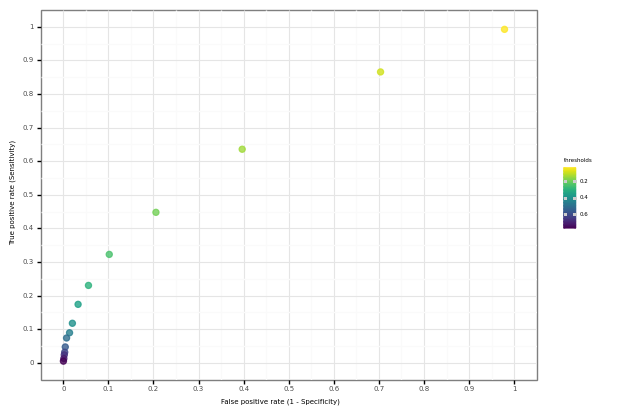

<ggplot: (136477444304)>

In [173]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)

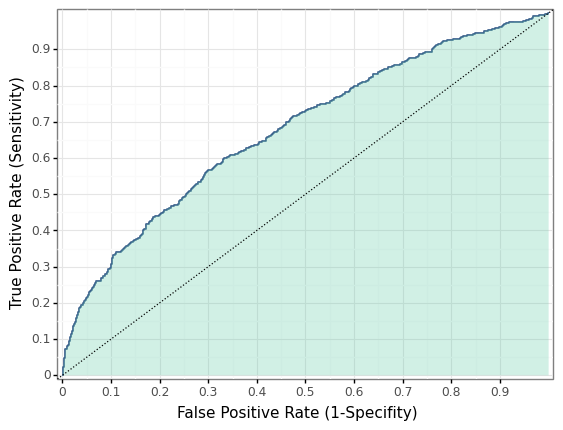

<ggplot: (136477599413)>

In [174]:
# continuous ROC on holdout with best model (Logit 4) -------------------------------------------

create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [175]:
# Confusion table with different tresholds ----------------------------------------------------------

# default: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no fast growth): ',counts[0])
print(values[1],' (fast growth): ',counts[1])

0  (no fast growth):  3737
1  (fast growth):  70


In [176]:
# confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm1

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3145,23
Actual fast-growing,592,47


In [188]:
# we can apply different thresholds

threshold = 0.3
holdout_prediction = np.where(logit_predicted_probabilities_holdout < threshold, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm1b

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,2991,177
Actual fast-growing,492,147


In [190]:
# a sensible choice: mean of predicted probabilities
mean_predicted_fast_growth_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_fast_growth_prob, 3)

0.165

In [191]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_fast_growth_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm2

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,2122,1046
Actual fast-growing,261,378


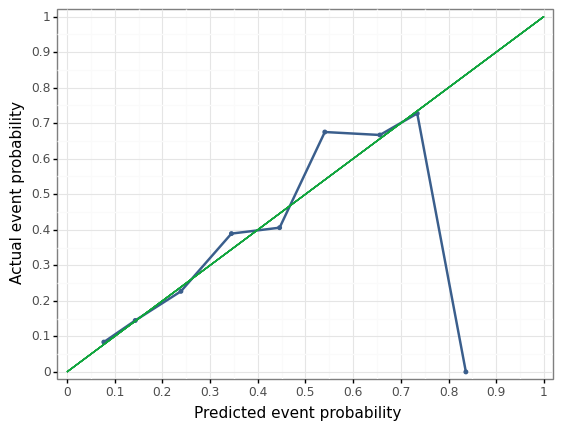

<ggplot: (136477604735)>

In [192]:
# Calibration curve -----------------------------------------------------------
# how well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(holdout, file_name = "ch17-figure-1-logit-m4-calibration",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)

# PART II: Classification

# PART III Discussion of results